In [7]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import sklearn

from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import sklearn

from sksurv.metrics import concordance_index_censored

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics.pairwise import euclidean_distances

import xgboost as xgb
import shap
import numpy as np
import pandas as pd
from math import sqrt
import scipy as sp

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
def fill_matrix_with_total_times(total_times : list,
                                 predicted_surv : np.ndarray,
                                 event_times : np.ndarray):
    """The model only outputs a prediction for the event times
       this function fills the gaps between them

    Args:
    total_times    : total number of time steps
    predicted_surv : array with the predicted survival times
    event_times    : array with the times where an event happened

    Returns:
    gl : list with a prediction for all the survival times

    """
    gl = [1]
    for time in total_times:
        try:
            if time in event_times:
                time_index = event_times.index(time)
                gl.append(predicted_surv[time_index])
            else:
                gl.append(gl[-1])
        except:
            import ipdb;ipdb.set_trace()
    # Quickfix to delete the one added at the beggining
    del gl[0]
    return gl

def compare_survival_times(bb_model : CoxPHSurvivalAnalysis,
                           coefs : np.ndarray,
                           X_train : pd.DataFrame, y_train : np.ndarray, X_test : pd.DataFrame, true_coef : list = None):

    times_train = [x[1] for x in y_train]
    times_to_fill = list(set(times_train)); times_to_fill.sort()
    
    model_interpretable = CoxPHSurvivalAnalysis(alpha=0.0001)
    model_interpretable.fit(X_train, y_train)
    model_interpretable.coef_ = coefs
    # Obtain the predictions from both models
    preds_bb      = bb_model.predict_survival_function(X_test)
    preds_survlime = model_interpretable.predict_survival_function(X_test)

   
    # We need to do this to have the same size as the cox output
    if isinstance(bb_model, RandomSurvivalForest):
        preds_bb_y  = np.mean([fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in preds_bb], axis=0)
    else:
        preds_bb_y  = np.mean([x.y for x in preds_bb], axis=0)

    preds_surv_y = np.mean([x.y for x in preds_survlime], axis=0)

    rmse = sqrt(mean_squared_error(preds_bb_y, preds_surv_y))
    if isinstance(bb_model, CoxPHSurvivalAnalysis):
        plot_num=2
        
        if true_coef:
            data  =  [bb_model.coef_, coefs, true_coef]
            index =  ['CoxPH', 'SurvLIME', 'True coef']
        else:
            data  = [bb_model.coef_, coefs]
            index = ['CoxPH','SurvLIME']
        df = pd.DataFrame(columns=bb_model.feature_names_in_, 
                  data=data, index=index)
        import ipdb;ipdb.set_trace()
        df = df.reindex(df.iloc[0].sort_values(ascending=False).index, axis=1)
        # Create axes and access them through the returned array
        fig, axs = plt.subplots(1, plot_num, figsize=(25,10))
        df.transpose().plot.bar(ax=axs[0])
        axs[0].set_title('Coefficient values for bb model and survlime')
        axs[1].step(preds_bb[0].x, preds_bb_y, where="post", label='BB model')
        axs[1].step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        axs[1].legend()
        axs[1].set_title(f'Mean survival time comparison RMSE: {rmse:.3}')
    # If we are using other model, we don't have coefficients to compare with
    else:
        plt.figure()
        plt.step(preds_survlime[0].x, preds_bb_y, where="post", label='BB model')
        plt.step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')
        plt.legend()
        plt.title(f'Mean survival time comparison RMSE: {rmse:.3}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from derma.general.preprocessing.transformers import (TransformToNumeric, 
                                                      TransformToDatetime, 
                                                      ComputeAge,
                                                      TransformToObject,
                                                      KeepColumns,
                                                      ComputeAJCC,
                                                      LinkTumourPartToParent,
                                                      TransformCbRegression,
                                                      ConvertCategoriesToNaN,
                                                      ExponentialTransformer,
                                                      RenameLabValues,
                                                      CustomScaler,
                                                      CustomImputer)

from derma.general.ingestion.data_loader_csv import SurvivalLoader
from derma.general.preprocessing.encoders import (OrdinalEncoder, #CustomOrdinalEncoder as 
                                                  GenderEncoder,
                                                  AbsentPresentEncoder,
                                                  LABEncoder,
                                                  CategoricalEncoder)
from derma.general.ingestion.data_loader_csv import SurvivalLoader


import config_os as settings_file





np.random.seed(123456)

get_target = lambda df: df[['event','duration']]
path = '/home/carlos.hernandez/datasets/csvs/data-surv_20220302.csv'


clinical_columns = ['patient_gender', 'patient_eye_color',
       'patient_phototype', 'cutaneous_biopsy_breslow',
       'cutaneous_biopsy_mitotic_index', 'cutaneous_biopsy_ulceration',
       'cutaneous_biopsy_neurotropism', 'cutaneous_biopsy_satellitosis', 'age',
       'primary_tumour_location_coded_acral',
       'primary_tumour_location_coded_head and neck',
       'primary_tumour_location_coded_lower limbs',
       'primary_tumour_location_coded_upper limbs',
       'primary_tumour_location_coded_mucosa',
       'cutaneous_biopsy_histological_subtype_acral_lentiginous',
       'cutaneous_biopsy_histological_subtype_desmoplastic',
       'cutaneous_biopsy_histological_subtype_lentiginous_malignant',
       'cutaneous_biopsy_histological_subtype_mucosal',
       'cutaneous_biopsy_histological_subtype_nevoid',
       'cutaneous_biopsy_histological_subtype_nodular',
       'cutaneous_biopsy_histological_subtype_spitzoid',
       'patient_hair_color_black', 'patient_hair_color_blond',
       'patient_hair_color_red']

lab_columns = ['Recompte de leucòcits', 'Recompte plaquetes', 'Neutròfils absoluts (anal)',
        'Limfòcits absoluts (analitzado', 'Monòcits absoluts (analitzador', 'Eosinòfils absoluts (analitzad',
        'Basòfils absoluts (analitzador', 'Aspartat aminotransferasa (ASA', 'Alanin aminotransferasa (ALAT)',
        'Gamma glutaril transferasa (GG', 'Bilirrubina total', 'Lactat deshidrogenasa (LDH)',
        'Glucosa', 'Creatinina plasmàtica', 'Colesterol total', 'Triglicèrids',
        'Proteïnes totals', 'Beta 2 microglobulina', 'Proteïna S100',
        'Melanoma Inhibitory activity', 'Concentració dhemoglobina']


X, _, time, event = SurvivalLoader('os').load_data(path)
X['duration'] = round(time)

X['event']    = event
X.dropna(subset=['duration'],inplace=True)
X = X[X['duration']>=0]
X.shape


(3703, 78)

In [9]:
pipe  = sklearn.pipeline.Pipeline(steps=[
    ('TransformToNumeric', TransformToNumeric(**settings_file.transform_to_numeric)), 
    ('TransformToDatetime', TransformToDatetime(**settings_file.transform_to_datetime)),
    ('TransformToObject', TransformToObject(**settings_file.transform_to_object)),
    ('ComputeAge', ComputeAge(**settings_file.compute_age)),
    ('tr_tm', LinkTumourPartToParent(**settings_file.link_tumour_part_to_parent)),
    ('tr_cb', TransformCbRegression(**settings_file.transform_cb_regression)),
    ('tr0', ConvertCategoriesToNaN(**settings_file.convert_categories_to_nan)),
    ('tr2', GenderEncoder(**settings_file.gender_encoder)),
    ('tr3', AbsentPresentEncoder(**settings_file.absent_present_encoder)),
    ("tr4", CategoricalEncoder(**settings_file.categorical_encoder)),
    ('tr7', LABEncoder(**settings_file.lab_encoder)),
    ('OrdinalEncoder', OrdinalEncoder(**settings_file.ordinal_encoder)),
    ('ComputeAJCC', ComputeAJCC(**settings_file.compute_ajcc)),
    ('tr5', ExponentialTransformer(**settings_file.exponential_transformer)),
    ('RenameLabValues', RenameLabValues(**settings_file.rename_lab_values)),

    ('KeepColumns', KeepColumns(**settings_file.keep_cols))
])

X_train, X_test, y_train, y_test = train_test_split(X.copy(), np.zeros(len(X)), test_size=0.2,
                                                    random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test.copy(), np.zeros(len(X_test)), test_size=0.5, 
                                                random_state=0)

fitted_pipe = pipe.fit(X_train.copy(), y_train_list.copy())

NameError: name 'y_train_list' is not defined

In [5]:
pd.set_option('display.max_columns', None)
X_train_t

NameError: name 'X_train_t' is not defined

In [10]:
total_c_index  = []
total_ib_score = []
def create_target(row):
    if row['event'] == 0:
        return -row['duration']
    return row['duration'] 
np.random.seed(123456)
#keep_cols = clinical_columns +lab_columns
#settings_file.keep_cols = {'cols' : keep_cols}

pipe = sklearn.pipeline.Pipeline(steps=[
    ('TransformToNumeric', TransformToNumeric(**settings_file.transform_to_numeric)), 
    ('TransformToDatetime', TransformToDatetime(**settings_file.transform_to_datetime)),
    ('TransformToObject', TransformToObject(**settings_file.transform_to_object)),
    ('ComputeAge', ComputeAge(**settings_file.compute_age)),
    ('tr_tm', LinkTumourPartToParent(**settings_file.link_tumour_part_to_parent)),
    ('tr_cb', TransformCbRegression(**settings_file.transform_cb_regression)),
    ('tr0', ConvertCategoriesToNaN(**settings_file.convert_categories_to_nan)),
    ('tr2', GenderEncoder(**settings_file.gender_encoder)),
    ('tr3', AbsentPresentEncoder(**settings_file.absent_present_encoder)),
    ("tr4", CategoricalEncoder(**settings_file.categorical_encoder)),
    ('tr7', LABEncoder(**settings_file.lab_encoder)),
    ('OrdinalEncoder', OrdinalEncoder(**settings_file.ordinal_encoder)),
    ('ComputeAJCC', ComputeAJCC(**settings_file.compute_ajcc)),
    ('tr5', ExponentialTransformer(**settings_file.exponential_transformer)),
    ('KeepColumns', KeepColumns(**settings_file.keep_cols)),
    ('RenameLabValues', RenameLabValues(**settings_file.rename_lab_values)),
    ('CustomImputer', CustomImputer(strategy='mean')),
    ('CustomScaler', CustomScaler()),
  #  ('EMImputer', ExpectationMaximizationImputer()),
#  ('CPH', CoxPHSurvivalAnalysis())
    ('xgb', RandomSurvivalForest(random_state=42))
#       ('clf', xgb.XGBRegressor(**config_defaults))
    ])


X_train, X_test, y_train, y_test = train_test_split(X.copy(), np.zeros(len(X)), test_size=0.2,
                                                    random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test.copy(), np.zeros(len(X_test)), test_size=0.5, 
                                                random_state=0)

y_train_list = get_target(X_train)
y_train_list = Surv.from_dataframe(*y_train_list.columns, y_train_list)
y_test_list = get_target(X_test)
y_test_list = Surv.from_dataframe(*y_test_list.columns, y_test_list)

fitted_pipe = pipe.fit(X_train.copy(), y_train_list.copy())

X_test_t = fitted_pipe[:-1].transform(X_test)
X_train_t = fitted_pipe[:-1].transform(X_train)


Index(['blue_nevi_count', 'decision_dx'], dtype='object')
Index(['blue_nevi_count'], dtype='object')
Index(['blue_nevi_count', 'decision_dx'], dtype='object')


In [26]:
pipe.score(X_test, y_test_list)

0.8504265281252005

In [9]:
model = CoxPHSurvivalAnalysis(alpha=0.0001)
#model = RandomSurvivalForest()
model.fit(X_train_t, y_train_list)
coef = model.coef_
compt_weights = pd.read_csv(f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp4/os/rsf_xxmm_surv_weights_rand_seed_0.csv')
model = fitted_pipe[-1]
dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))


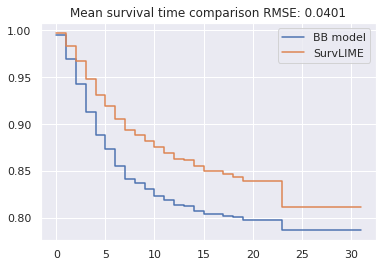

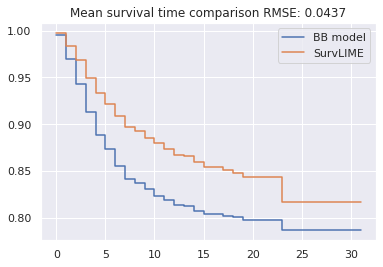

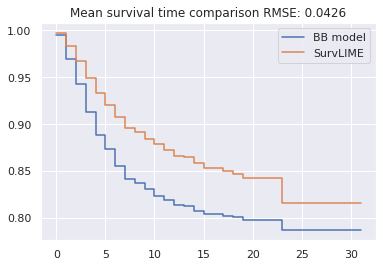

In [10]:
compare_survival_times(model, compt_weights.iloc[closest], X_train_t, y_train_list, X_test_t)
compare_survival_times(model, compt_weights.iloc[furthest], X_train_t, y_train_list, X_test_t)
compare_survival_times(model, compt_weights.mean(), X_train_t, y_train_list, X_test_t)

### Here we compute the Confidence Intervals

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.93it/s]


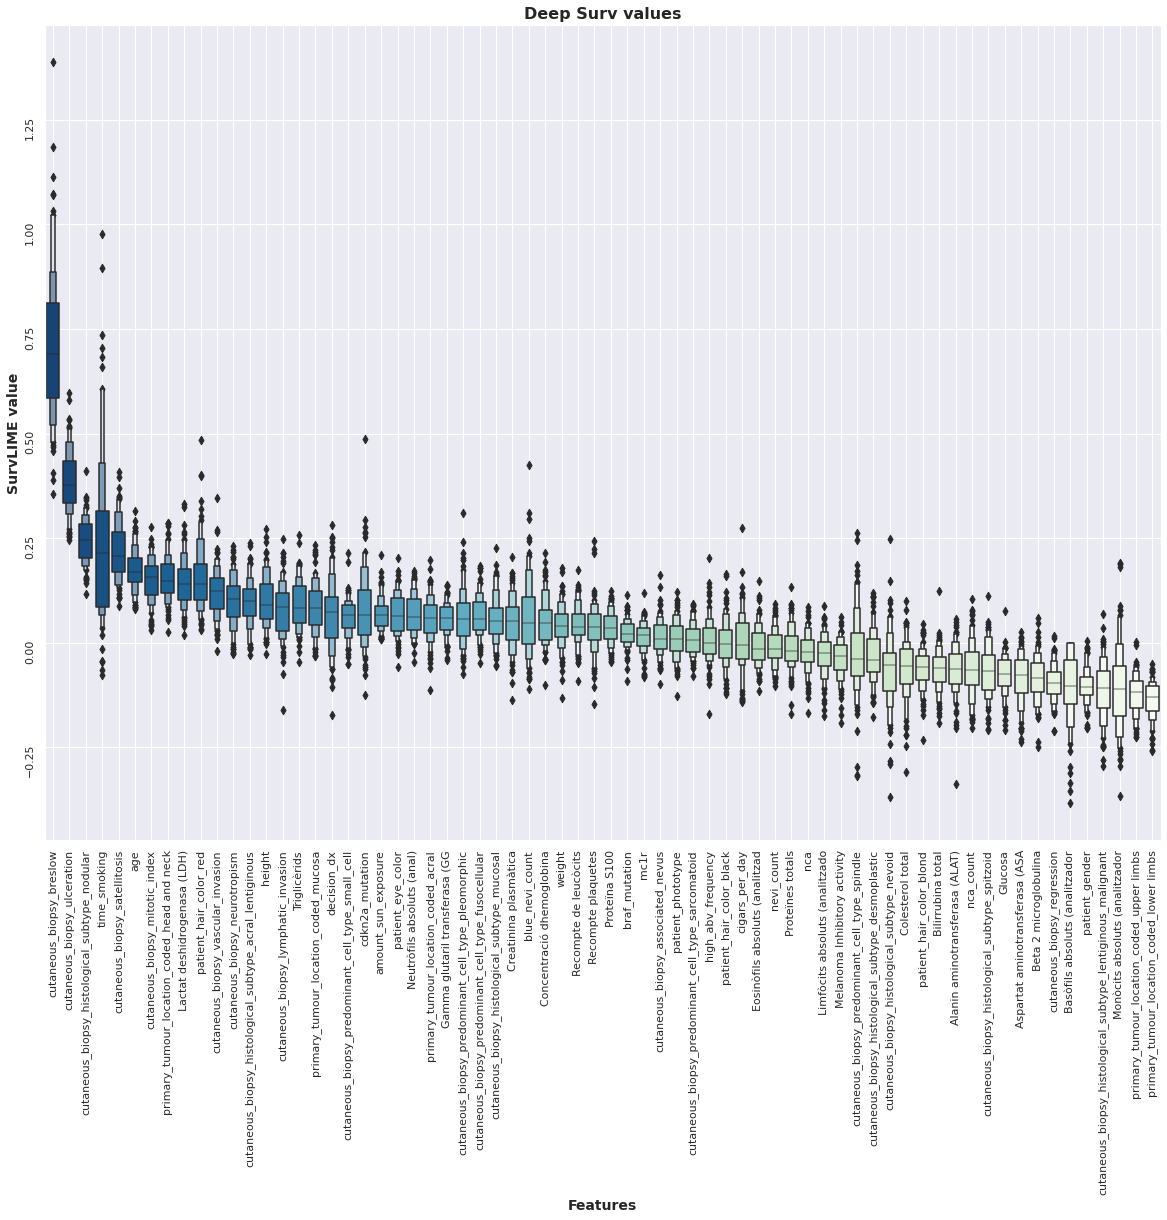

In [5]:
from tqdm import tqdm

mean_dfs, max_dfs, min_dfs = [], [], []
event = 'ss'


w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp4/DeepSurv/{event}/'


for i in tqdm(range(100)):
    compt_weights = pd.read_csv(w_path+f'DeepSurv_xxmm_surv_{event}_weights_rand_seed_{i}.csv')
    compt_weights = compt_weights.dropna(axis=0)
    
    mean_dfs.append(compt_weights.mean())

    
dfs_together_mean= pd.concat(mean_dfs, axis=1).transpose()

dfs_together_mean = dfs_together_mean.reindex(dfs_together_mean.median().sort_values(ascending=False).index, axis=1)


fig, ax= plt.subplots(1,1, figsize=(20,15), sharey=True)


flierprops = dict(marker='o', markersize=5, markeredgecolor='black'
                  , markerfacecolor='green', alpha=0.5)

p = sns.boxenplot(x="variable", y="value", data=pd.melt(dfs_together_mean),
                                    ax=ax, palette='GnBu_r') #'GnBu_r'
ax.tick_params(labelrotation=90); ax.xaxis.grid(True)
p.set_xlabel('Features', fontsize= 14, fontweight='bold')
p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
p.set_title('Deep Surv values', fontsize= 16, fontweight='bold')
plt.savefig(f'figures/DeepSurv_{event}_survlime.png', pad_inches=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 161.09it/s]


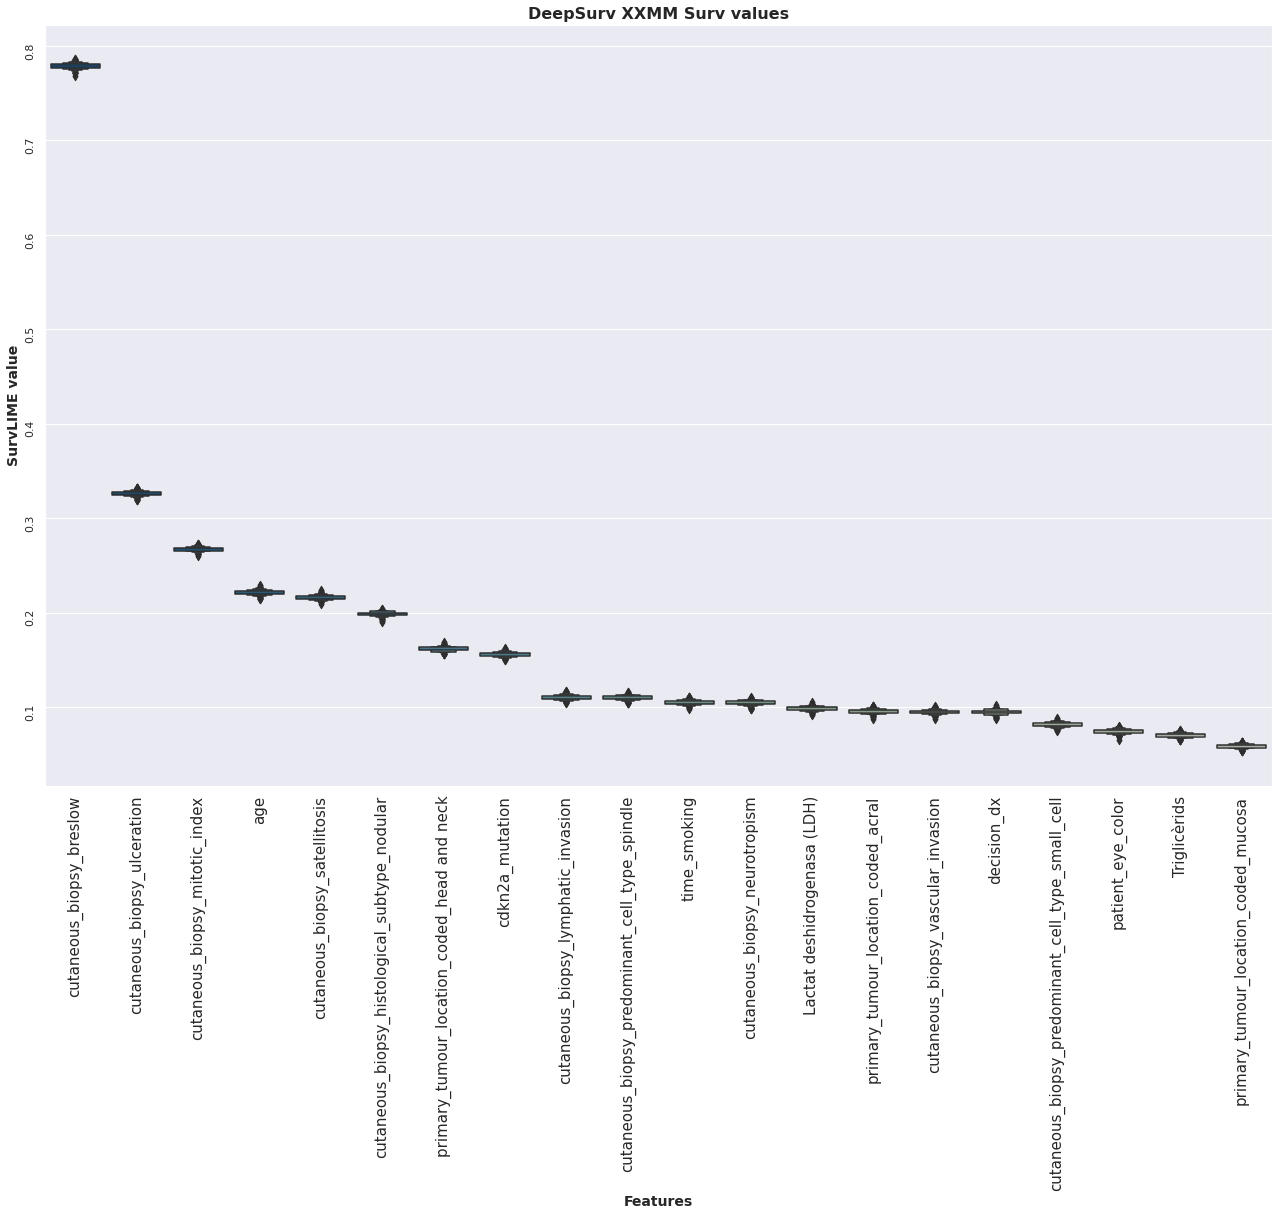

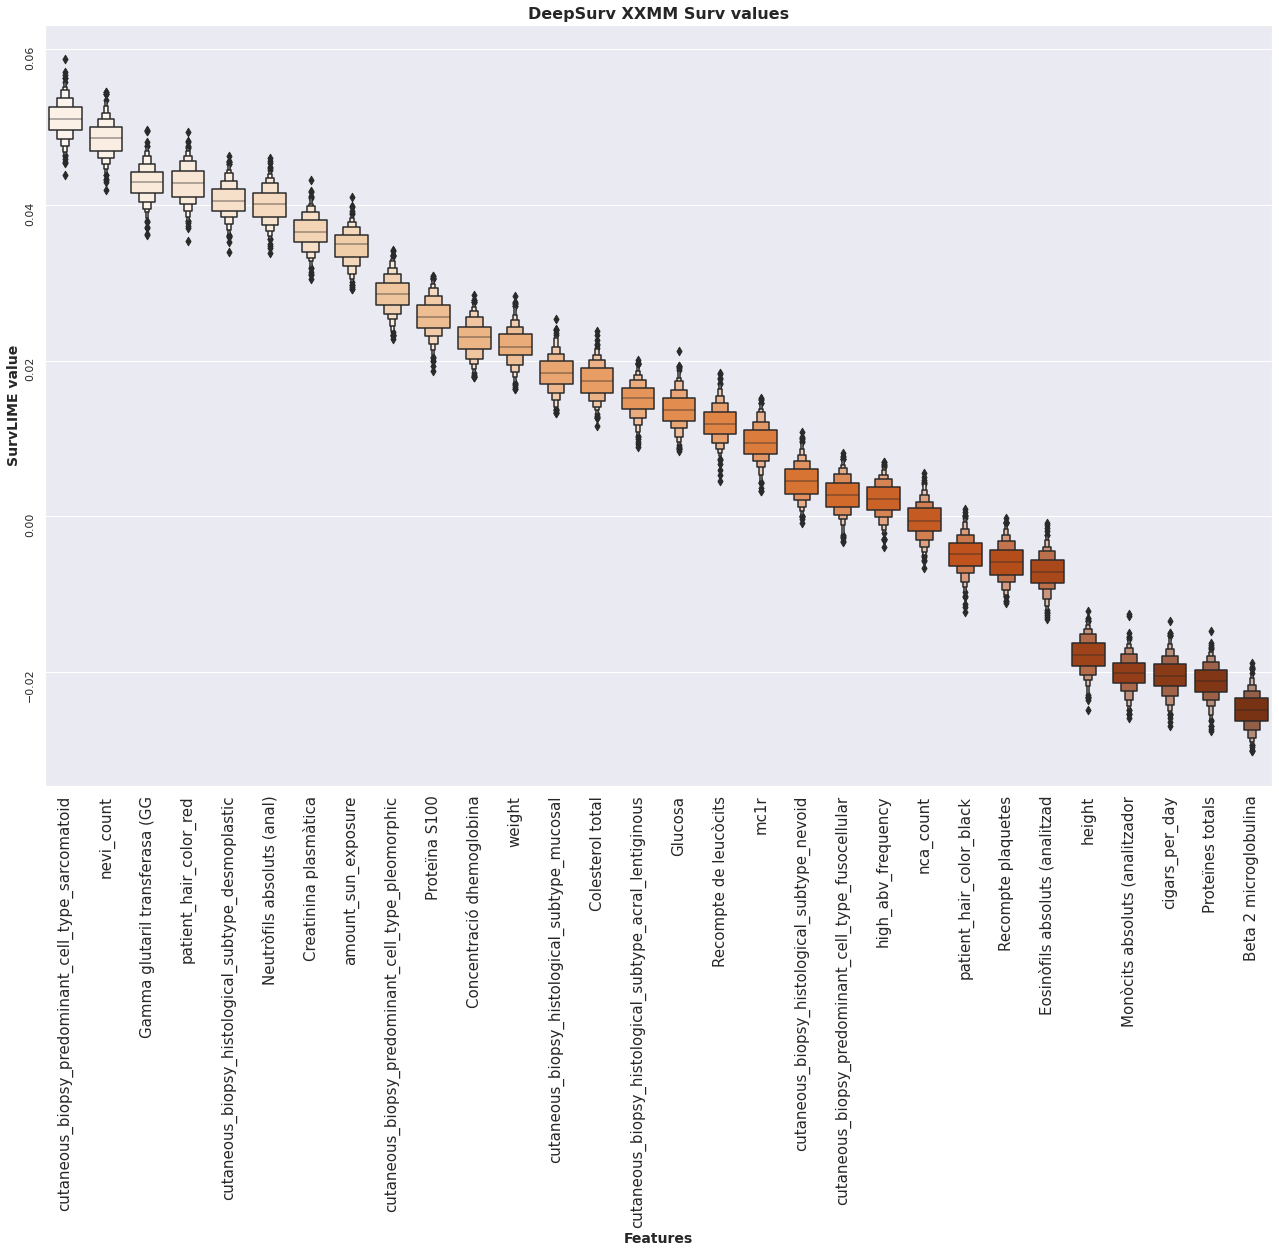

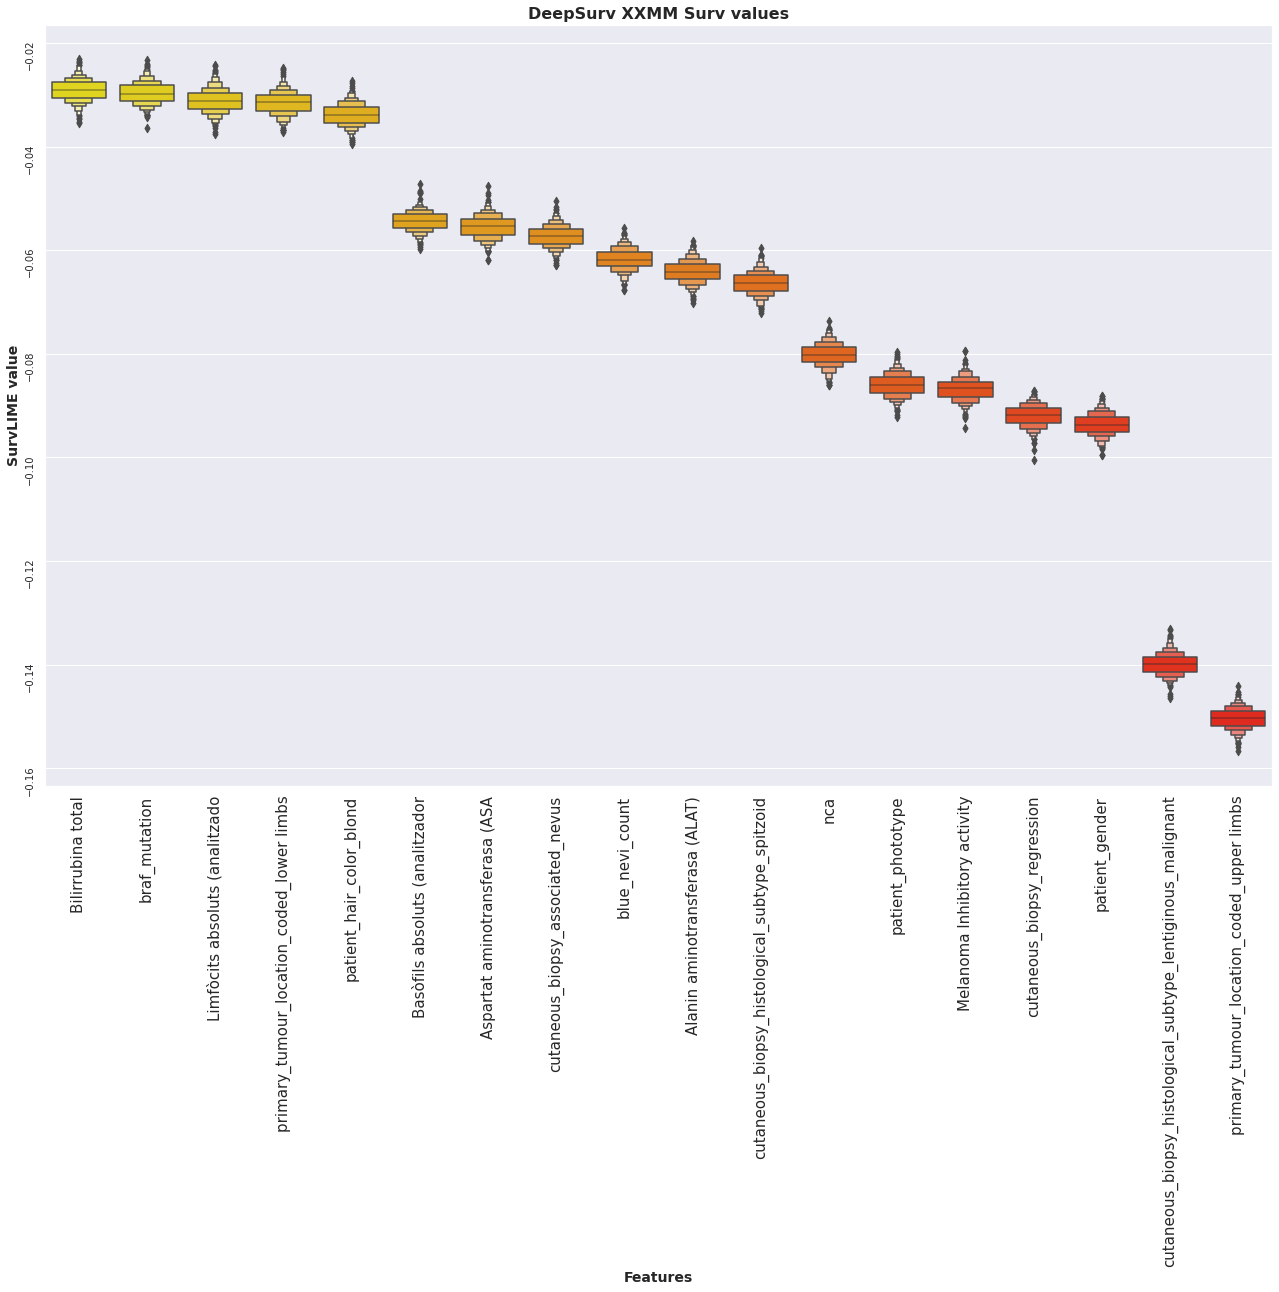

In [13]:
from tqdm import tqdm

mean_dfs, max_dfs, min_dfs = [], [], []
event_type = 'dfs'
model_type='DeepSurv'

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp4/DeepSurv/{event_type}/'

length = 100
surv_volume = np.ndarray((length, 368, 68))
#surv_ = np.ndarray((371, 68))
good_ones = []
for i in tqdm(range(length)):
    compt_weights = pd.read_csv(w_path+f'{model_type}_xxmm_surv_{event_type}_weights_rand_seed_{i}.csv')
    compt_weights = compt_weights.dropna(axis=0)
    try:
        surv_volume[i] = compt_weights.to_numpy()
        good_ones.append(i)
    except:
        pass
        print(i)
        
surv_volume = surv_volume[good_ones]

pru = pd.DataFrame(data=surv_volume.mean(axis=0), columns=X_train_t.columns)
pru = pru.reindex(pru.mean().sort_values(ascending=False).index, axis=1)


fig, ax= plt.subplots(1,1, figsize=(22,14), sharey=True)
ax.tick_params(labelrotation=90); ax.xaxis.grid(True)

p = sns.boxenplot(x="variable", y="value", data=pd.melt(pru.iloc[:,0:20]),
                                    ax=ax, palette='GnBu_r') #'GnBu_r'
ax.tick_params(labelrotation=90); #ax.xaxis.grid(True)
p.set_xlabel('Features', fontsize= 14, fontweight='bold')
p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
#p.set_ylim([-0.01, 0.28])
p.set_title(f'{model_type} XXMM Surv values', fontsize= 16, fontweight='bold');
ax.tick_params(axis='x', which='major', labelsize=15)

plt.savefig(f'figures/{model_type}_{event_type}_most_survlime.png',  bbox_inches='tight', dpi=200)


fig, ax= plt.subplots(1,1, figsize=(22,14), sharey=True)
ax.tick_params(labelrotation=90); ax.xaxis.grid(True)
p = sns.boxenplot(x="variable", y="value", data=pd.melt(pru.iloc[:,20:50]),
                                    ax=ax, palette='Oranges') #'GnBu_r'
ax.tick_params(labelrotation=90); #ax.xaxis.grid(True)
#p.set_ylim([-0.03, 0.05])
p.set_xlabel('Features', fontsize= 14, fontweight='bold')
p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
p.set_title(f'{model_type} XXMM Surv values', fontsize= 16, fontweight='bold');
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', labelsize=15)

plt.savefig(f'figures/{model_type}_{event_type}_medium_survlime.png',  bbox_inches='tight', dpi=200)



fig, ax= plt.subplots(1,1, figsize=(22,14), sharey=True)
ax.tick_params(labelrotation=90); ax.xaxis.grid(True)

p = sns.boxenplot(x="variable", y="value", data=pd.melt(pru.iloc[:,50:]),
                                    ax=ax, palette='autumn_r') #'GnBu_r'
ax.tick_params(labelrotation=90, labelsize=10); #ax.xaxis.grid(True)
p.set_xlabel('Features', fontsize= 14, fontweight='bold')
ax.tick_params(axis='x', which='major', labelsize=15)
#p.set_ylim([-0.06, 0.02])
p.set_ylabel('SurvLIME value', fontsize= 14, fontweight='bold')
p.set_title(f'{model_type} XXMM Surv values', fontsize= 16, fontweight='bold');
plt.savefig(f'figures/{model_type}_{event_type}_least_survlime.png',  bbox_inches='tight', dpi=200)

In [17]:
compt_weights = pd.read_csv(w_path+f'{model_type}_xxmm_surv_weights_rand_seed_0.csv')

compt_weights_val = compt_weights.to_numpy()

In [ ]:
#setattr(compt_weights_val,'base_values', X_test_t.to_numpy())

In [20]:
from tqdm import tqdm

mean_dfs, max_dfs, min_dfs = [], [], []
w_path = '/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp4/ss/'

surv_volume = np.ndarray((100, 371, 68))

model_type='rsf'
for i in tqdm(range(100)):
    compt_weights = pd.read_csv(w_path+f'{model_type}_xxmm_surv_ss_weights_rand_seed_{i}.csv')
    compt_weights = compt_weights.dropna(axis=0)
    surv_volume[i] = compt_weights.to_numpy() 
    
dfs_together_mean= pd.concat(mean_dfs, axis=1).transpose()
dfs_together_min= pd.concat(min_dfs, axis=1).transpose()
dfs_together_max= pd.concat(max_dfs, axis=1).transpose()

dfs_together_mean = dfs_together_mean.reindex(dfs_together_mean.mean().sort_values(ascending=False).index, axis=1)
dfs_together_min = dfs_together_min.reindex(dfs_together_min.iloc[0].sort_values(ascending=False).index, axis=1)
dfs_together_max = dfs_together_max.reindex(dfs_together_max.iloc[0].sort_values(ascending=False).index, axis=1)

fig, ax= plt.subplots(1,1, figsize=(20,15), sharey=True)
sns.boxplot(x="variable", y="value", data=pd.melt(dfs_together_mean.quantile(q=[0.05, 0.95], axis=0)), ax=ax)
ax.set_title('Mean'); ax.tick_params(labelrotation=90); ax.xaxis.grid(True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.20it/s]


ValueError: No objects to concatenate

In [32]:

pru = pd.DataFrame(data=surv_volume.mean(axis=0), columns=X_train_t.columns)

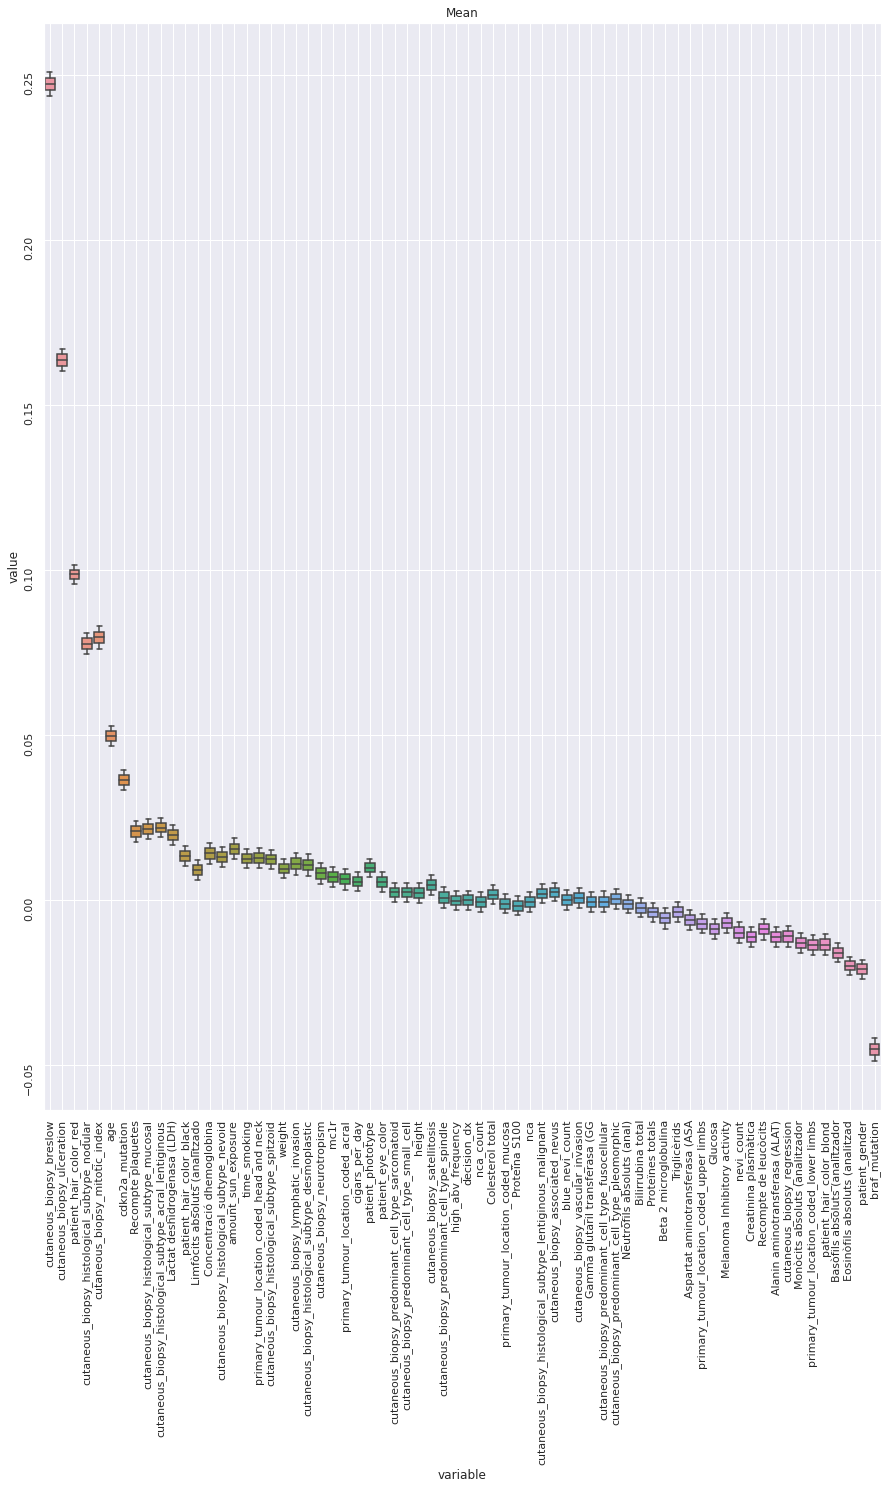

In [37]:
pru = pru.reindex(pru.iloc[0].sort_values(ascending=False).index, axis=1)

fig, ax= plt.subplots(1,1, figsize=(15,20), sharey=True)
sns.boxplot(x="variable", y="value", data=pd.melt(pru.quantile(q=[0.05, 0.95], axis=0)), ax=ax)
ax.set_title('Mean'); ax.tick_params(labelrotation=90); ax.xaxis.grid(True)